In [1]:
import logging
import hydra
import pandas as pd


from collections import defaultdict
from tqdm import tqdm 

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.patches import Ellipse

from erc import drawing_ellipse, split_df_by_gender
from sklearn.cluster import KMeans
import logging
import hydra
import torch.nn as  nn 
import erc
from torch.utils.data import DataLoader
from datasets import load_from_disk
import pandas as pd


from erc.constants import idx2emotion, emotion2idx

# generate dataset 
train_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_train4_multilabelFalse_rdeuceTrue")
valid_dataset = load_from_disk("/home/hoesungryu/etri-erc/kemdy19-kemdy20_valid4_multilabelFalse_rdeuceTrue")


total_dict = {}
for key_ in ['emotion', 'valence','arousal']:
    
    tmp = pd.concat([pd.DataFrame(train_dataset[key_]),
                    pd.DataFrame(valid_dataset[key_])], axis=0)
    total_dict[key_] = tmp  

total = pd.concat([total_dict['emotion'], total_dict['valence'],total_dict['arousal']], axis=1)
total.columns = ['emotion', 'valence','arousal']


In [2]:
total

,emotion,valence,arousal
0,0,1.7,4.0
1,1,1.5,3.6
2,2,1.3,4.3
3,2,1.5,3.8
4,1,1.6,3.7
...,...,...,...
4673,3,3.0,3.0
4674,0,2.7,3.5
4675,3,2.9,3.5
4676,3,2.3,3.5


## Emotion EDA

In [3]:
def generate_eva_dict(df_: pd.DataFrame) -> dict:
    """
    Summary: 
        감정 별 Valence Arousal mean, std 
    """
    # idx2emotion = {v:k for k,v in emotion2idx.items()}
    idx2emotion = {0: 'surprise',
    1: 'fear',
    2: 'angry',
    3: 'neutral',
    4: 'happy',
    5: 'sad',
    6: 'disgust'}
    
    choice_col = ['valence','arousal']
    mean_std_dict = defaultdict(dict)
    for emotion_idx in df_['emotion'].unique():
        means = df_[df_['emotion'] == emotion_idx][choice_col].mean(axis=0).values
        stds = df_[df_['emotion'] == emotion_idx][choice_col].std(axis=0).values

        tmp_dict = {
            'valence_mean': means[0],
            'arousal_mean' : means[1],
            'valence_std' : stds[0],
            'arousal_std': stds[1]
        }

        mean_std_dict[idx2emotion.get(emotion_idx)] = tmp_dict
    return mean_std_dict

In [4]:
idx2emotion = {0: 'Surprise',
 1: 'Fear',
 2: 'Angry',
 3: 'Neutral',
 4: 'Happy',
 5: 'Sad',
 6: 'Disgust'}

In [5]:
mean_std_dict = generate_eva_dict(total)

In [6]:
aa = total.copy()
aa['emotion'] = aa['emotion'].map(idx2emotion)

In [7]:
aa

,emotion,valence,arousal
0,Surprise,1.7,4.0
1,Fear,1.5,3.6
2,Angry,1.3,4.3
3,Angry,1.5,3.8
4,Fear,1.6,3.7
...,...,...,...
4673,Neutral,3.0,3.0
4674,Surprise,2.7,3.5
4675,Neutral,2.9,3.5
4676,Neutral,2.3,3.5


In [8]:
# aa = aa.sort_values('emotion')

In [9]:
aa['emotion'].unique()

array(['Surprise', 'Fear', 'Angry', 'Neutral', 'Happy', 'Sad', 'Disgust'],
      dtype=object)

/tmp/ipykernel_1214356/1236470910.py:27: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  ax = sns.scatterplot(x='arousal', y='valence', data=aa,


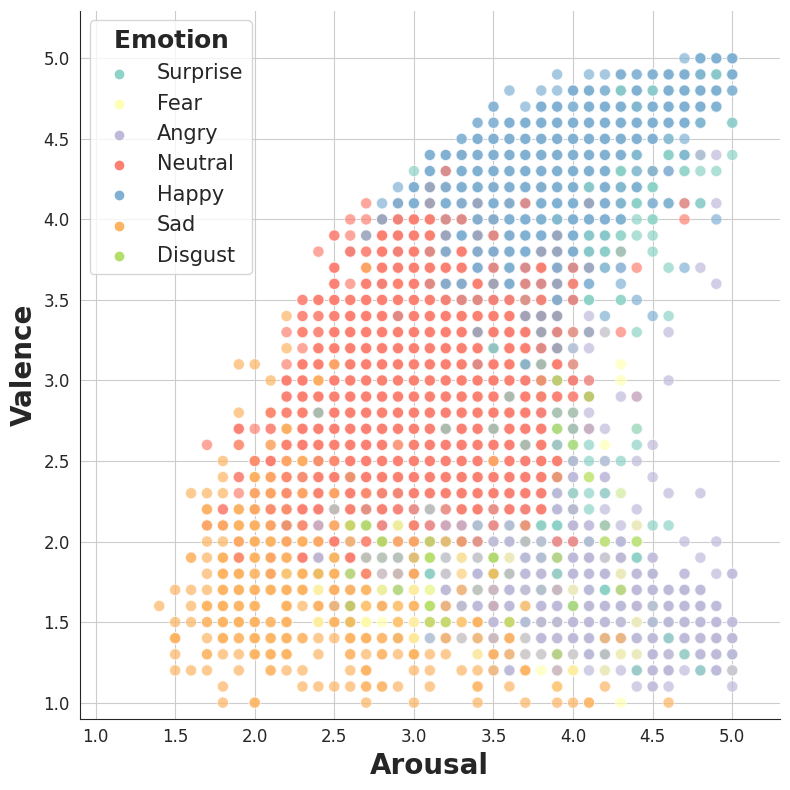

In [10]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns 
sns.set_style("whitegrid")

color_palette = sns.color_palette("Set3")
label_fsize = 20
ticks_fsize = 12
legend_size = 15
plt.rcParams["axes.edgecolor"] = "0.15"

_, ax = plt.subplots(figsize=(8, 8))
# for idx, emotion in enumerate(mean_std_dict.keys()):
#     tmp_dict = mean_std_dict[emotion]
#     x,y, width, height = tmp_dict.values()

#     ell = Ellipse(xy=(x, y),
#                     width=width,
#                     height=height,
#                     color=color_palette[idx],
#                     fill=False,
#                     label=emotion,
#                     alpha=0.9)
#     ax.add_artist(ell)
ax = sns.scatterplot(x='arousal', y='valence', data=aa, 
                     hue="emotion",
                    #  style="emotion",
                     palette = color_palette,
                     s=65,
                         alpha=0.7)
ax.set_xlim((0.9, 5.3))
ax.set_ylim((0.9, 5.3))
ax.legend()

# ax.set_yticklabels([i for i in range(1,5+1)], size = ticks_fsize)
# ax.set_xticklabels([i for i in range(1,5+1)], size = ticks_fsize)

ax.spines['right'].set_color(None)
ax.spines['top'].set_color(None)
# ax.set(xscale="log")
# plt.title(title)
plt.rcParams["axes.edgecolor"] = "0.15"
# plt.grid()
# plt.xlim(0.7, 5.3)
# plt.ylim(0.7, 5.3)
plt.legend(
            loc='best',
            # loc='lower right',
           fontsize=legend_size,title=r'$\bf{Emotion}$',frameon=True,
           fancybox=True ,
           title_fontsize=18,
         #   title_fontweight='bold'
        #    bbox_to_anchor=(1.2, 0)
         # title_fontproperties={'weight':'bold'}
           )
# plt.legend(title="Confidence \n Bands", title_fontproperties={'weight':'bold'})
plt.xlabel('Arousal', fontweight='bold', fontsize=label_fsize)
plt.ylabel('Valence', fontweight='bold', fontsize=label_fsize)
plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],size = ticks_fsize)
plt.yticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],size = ticks_fsize)
plt.tight_layout()
plt.savefig('./etri-eda_total.svg')
plt.show()

In [ ]:
[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

In [68]:
[i for i in range(1,5+1)]

[1, 2, 3, 4, 5]

In [22]:
idx2emotion

{0: 'surprise',
 1: 'fear',
 2: 'angry',
 3: 'neutral',
 4: 'happy',
 5: 'sad',
 6: 'disqust'}

In [18]:
total_dict=split_df_by_gender(total)
male_dict,female_dict = split_df_by_gender(total, total=False)


KeyError: 'gender'

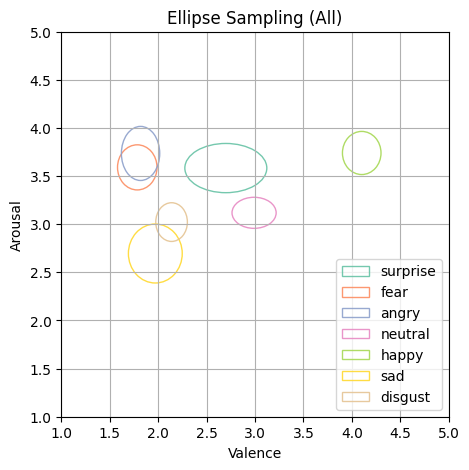

In [ ]:
drawing_ellipse(total_dict)

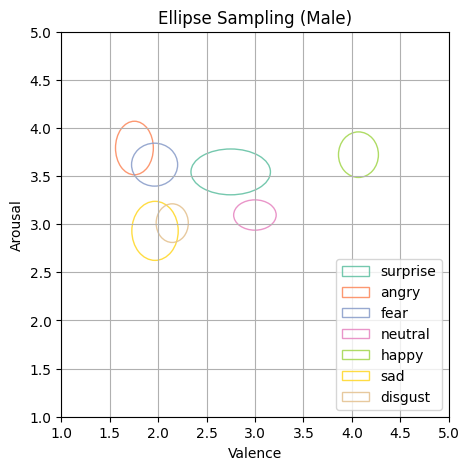

In [8]:
drawing_ellipse(male_dict, title='Ellipse Sampling (Male)')


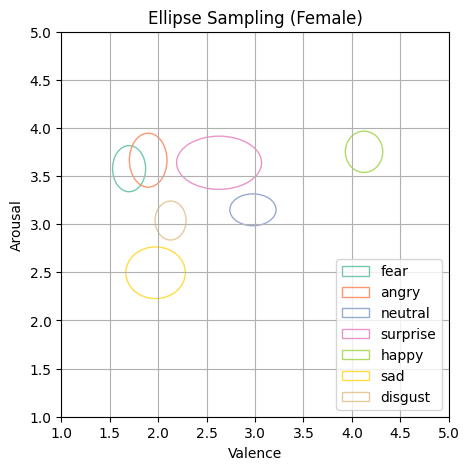

In [9]:
drawing_ellipse(female_dict, title='Ellipse Sampling (Female)')

/tmp/ipykernel_669452/123573891.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(['surprise', 'fear', 'angry', 'neutral', 'happy', 'sad', 'disgust'])


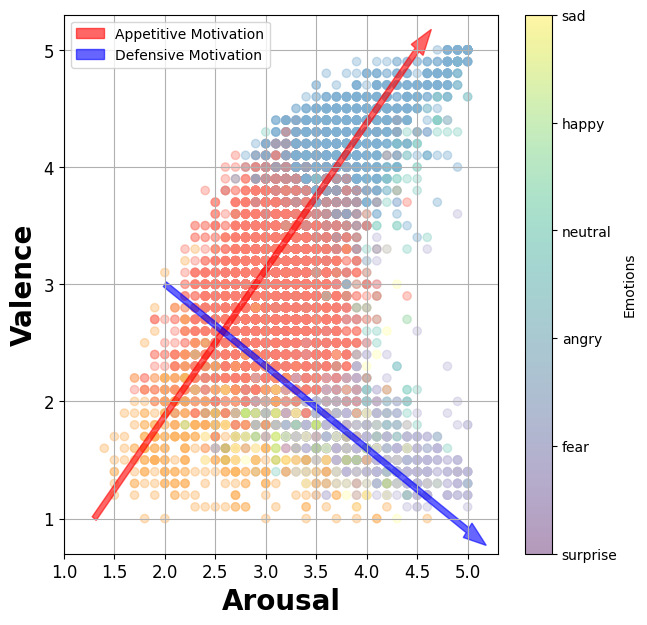

In [10]:

# refer : IAPS affective rating


color_palette   = mpl.colormaps['viridis']
# cmap = cm.bwr ## 또는 plt.cm.get_cmap('bwr')
vmax = 6
vmin = 0
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
colormapping = cm.ScalarMappable(norm=norm, cmap=color_palette)


sns_palette = sns.color_palette('Set3')

label_fsize = 20
ticks_fsize = 12
legend_size = 10

plt.figure(figsize=(7,7))
plt.scatter(df['arousal'], df['valence'],
            color=[sns_palette[int(i)] for i in df['emotion']],
            # cmap = colormapping,
            alpha=0.4)


plt.arrow(1.3, 1, 3.2,4, width = 0.05 ,label='Appetitive Motivation', alpha=0.6,color='red')
plt.arrow(2, 3,   3, -2.1,width = 0.05 ,label='Defensive Motivation', alpha=0.6,color='blue')




plt.xlabel('Arousal', fontweight='bold', fontsize=label_fsize)
plt.ylabel('Valence', fontweight='bold', fontsize=label_fsize)
plt.xlim(1,5.3)
plt.ylim(0.7,5.3)
plt.grid(True)
plt.yticks(fontsize=ticks_fsize, fontweight='normal')
plt.xticks(fontsize=ticks_fsize,
            fontweight='normal',
            )
plt.legend(loc='upper left',fontsize=legend_size,)

cb = plt.colorbar(label='Emotions', ax=plt.gca())
# cb.set_ticks([0,1,2,3,4,5,6])
cb.set_ticklabels(['surprise', 'fear', 'angry', 'neutral', 'happy', 'sad', 'disgust'])
# plt.legend(,
            #    loc='upper left',
            #    fontsize=legend_size,
            #    )
plt.show()

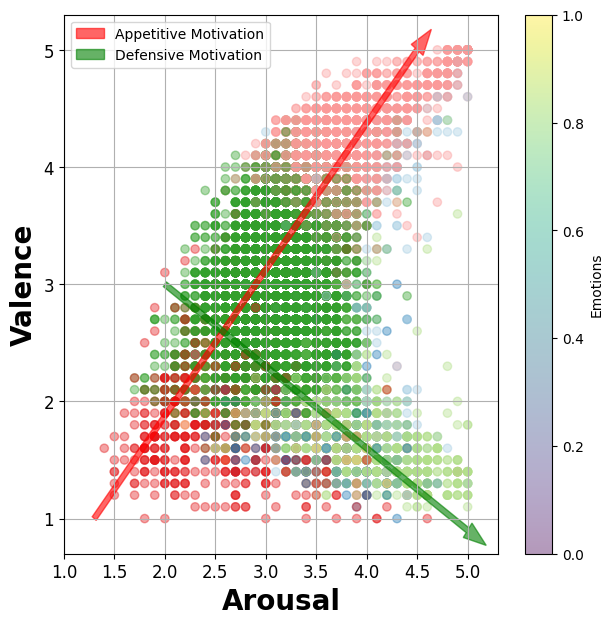

In [11]:
# refer : IAPS affective rating

color_palette = sns.color_palette("Paired")
label_fsize = 20
ticks_fsize = 12
legend_size = 10

plt.figure(figsize=(7,7))


plt.scatter(df['arousal'], df['valence'],
            # color=[f'C{int(i)}' for i in df['emotion']],
            color=[color_palette[int(i)] for i in df['emotion']],
            # edgecolors='black',linewidth=1,
            # label=df['emotion'],
            # label=[f'{emotion_r.get(i)}' for i in df['emotion']],
            alpha=0.4)


# plt.plot([1.3,4.7],[1,5.2],label='Appetitive Motivation', alpha=0.9,color='red')
plt.arrow(1.3, 1, 3.2,4, width = 0.05 ,label='Appetitive Motivation', alpha=0.6,color='red')
# plt.plot([2,5.2],[3,1],label='Appetitive Motivation', alpha=0.7,color='green')
plt.arrow(2, 3,   3, -2.1,width = 0.05 ,label='Defensive Motivation', alpha=0.6,color='green')
# plt.plot(x,z,label='z=3x')
# plt.legend(bbox_to_anchor=(1,1))

# [ 출처: https://seong6496.tistory.com/ ]



plt.xlabel('Arousal', fontweight='bold', fontsize=label_fsize)
plt.ylabel('Valence', fontweight='bold', fontsize=label_fsize)
plt.xlim(1,5.3)
plt.ylim(0.7,5.3)
plt.grid(True)
plt.yticks(fontsize=ticks_fsize, fontweight='normal')
plt.xticks(fontsize=ticks_fsize,
            fontweight='normal',
            )
plt.legend(loc='upper left',fontsize=legend_size,)



from matplotlib.colors import ListedColormap
# cmap = 
# cmap = ListedColormap(sns.color_palette("Paired"))
plt.colorbar(label='Emotions', ax=plt.gca())

# cb = plt.colorbar(label='Emotions', ax=plt.gca())

# cb.set_ticks([0,1,2,3,4,5,6])
# cb.set_ticklabels(, ,['surprise', 'fear', 'angry', 'neutral', 'happy', 'sad', 'disgust'])
# plt.legend(,
            #    loc='upper left',
            #    fontsize=legend_size,
            #    )
plt.show()


/home/hoesungryu/.conda/envs/etri-erc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


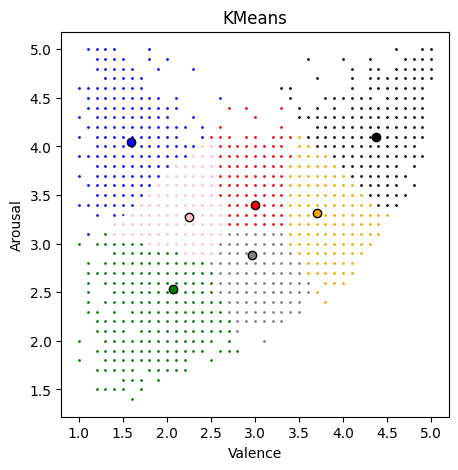

In [14]:
colors = ['black', 'red', 'blue', 'orange', 'pink', 'grey', 'green']
values= df[['valence','arousal']].values


kmeans_model = KMeans(n_clusters=7, random_state=0)
kmeans_model.fit(values)

k_means_labels = kmeans_model.predict(values)
k_means_cluster_centers = kmeans_model.cluster_centers_

fig, ax = plt.subplots(figsize=(5, 5))
for k, col in zip(range(7), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(values[my_members, 0], values[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
    
ax.set_title('KMeans')
ax.set_xlabel("Valence")
ax.set_ylabel("Arousal")
plt.show()

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
def get_accuracy(df, label = 'emotion', drop_col=[]):
        if len(drop_col) != 0:
                df = df.drop(drop_col, axis=1)

        X = df.drop([label],axis=1)
        y = df[label]

        model = RandomForestClassifier()
        predicted = cross_val_predict(model, X, y, cv=10)

        acc = accuracy_score(y, predicted)
        # auc = roc_auc_score(y, predicted,average='weighted', multi_class='ovo')
        f1 = f1_score(y, predicted, average='weighted')

        print(f'CV Acc: {acc:.4f}')
        # print(f'CV AUC: {auc:.4f}')
        print(f'CV F1: {f1:.4f}')
        print(' ')

print(get_accuracy(df, label='emotion'))
print(get_accuracy(df, label='emotion', drop_col='gender'))
print(get_accuracy(df, label='gender'))

CV Acc: 0.8038
CV F1: 0.7799
 
None
CV Acc: 0.8074
CV F1: 0.7783
 
None
CV Acc: 0.5737
CV F1: 0.5612
 
None
